In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path

## Download data from FBRef

In [4]:
fbref = 'https://fbref.com'

In [5]:
def get_all_teams():
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    all_teams_response = requests.get(fbref + '/en/comps/1/stats/World-Cup-Stats', headers=headers)

    soup = BeautifulSoup(all_teams_response.text)
    all_teams_table = soup.find('table', {'id':'stats_squads_standard_for'})
    if not all_teams_table:
        raise ValueError('Can\'t fetch data from FBref')
    teams = [
        (a.text, a['href']) for a in
        [
            
        th.find('a') for th in
        all_teams_table.find_all('th', {'data-stat':'team'})
        ] if a
    ]
    return teams

In [6]:
def get_players(team_url):
    all_teams_response = requests.get(fbref + team_url)
    soup = BeautifulSoup(all_teams_response.text)
    roster = soup.find('table', {'id':'roster'})
    properties = [h['aria-label'] for h in roster.find('thead').find('tr').find_all('th')]
    rows = roster.find('tbody').find_all('tr')
    players = []
    for row in rows:
        children = row.find_all(recursive=False)
        players.append({
            prop: ch.text for prop, ch in
            zip(properties, children)
        })
    return players

In [16]:
players_file = Path('players.csv')

if not players_file.exists():
    teams = get_all_teams()
    all_players = []
    for team_name, url in teams:
        try:
            players = get_players(url)
            for p in players:
                p['Country'] = team_name
                all_players.append(p)
        except:
            print(url)
            break
    players = pd.DataFrame(all_players)
    players = players[[ "Country", "Shirt Number", "Player", "Position", "Club", "Birth Place", "Birth Date"]]
    players.to_csv(players_file, index=False)
else:
    players = pd.read_csv(players_file)

## Calculate lengths

In [17]:
players['Name Length'] = players['Player'].str.len()
name_lengths = players.groupby('Country').mean().sort_values(by='Name Length')
name_lengths = name_lengths.reset_index()

/var/folders/26/kknv0qdn23x8cn86y7p06j4r0000gp/T/ipykernel_25990/4275801242.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  name_lengths = players.groupby('Country').mean().sort_values(by='Name Length')


## Download and save flags

In [18]:
from urllib.parse import quote

In [19]:
def norm_country(country):
    map = {
        'IR Iran': 'iran',
        'Korea Republic': 'the republic of korea',
    }
    return map.get(country, country).lower()
name_lengths['country norm'] = name_lengths['Country'].map(norm_country)

In [27]:
flags = Path('flags')
flags.mkdir(exist_ok=True)
for country in name_lengths['country norm']:
    flag_path = Path(flags, f'{country}.svg')
    if not flag_path.exists():        
        r = requests.get(f'https://countryflagsapi.com/svg/{quote(country)}')
        with open(flag_path,'wb') as f:
            f.write(r.content)

## Plot

In [35]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, AnchoredText
from PIL import Image, ImageOps
import numpy as np
import cairosvg
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

In [36]:
import PIL
print(PIL.__version__)

9.3.0


Text(0.5, 1.0, "Mean player's name length")

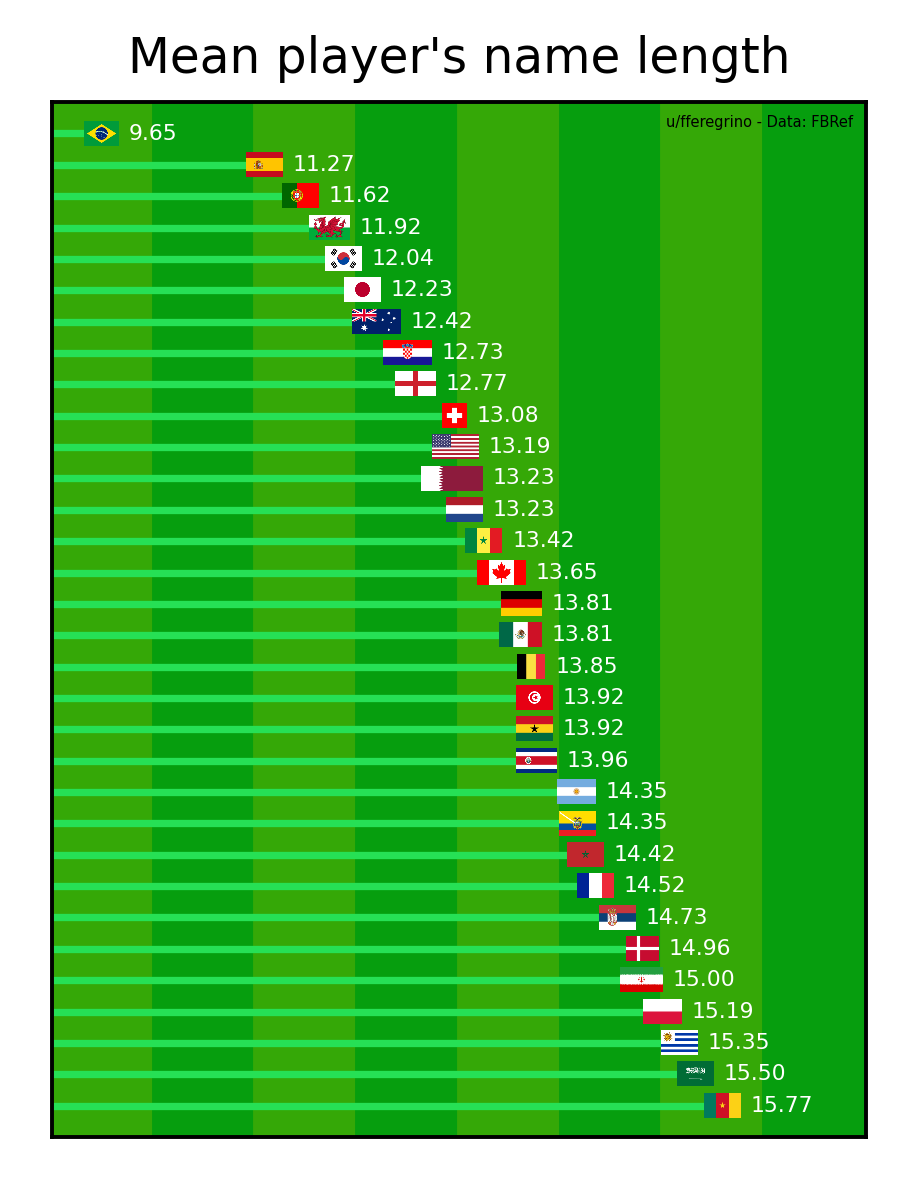

In [47]:
data = name_lengths.iloc[:32].copy()
inches_per_flag = 0.12

fig = plt.figure(figsize=(3,len(data)*inches_per_flag), dpi=350)
ax = fig.gca()

def get_flag(country):
    flag_path = Path(flags, f'{country}.svg')

    with open(flag_path) as flag_content:
        img_png = cairosvg.svg2png(
            flag_content.read(), 
            output_height=100)
        img = Image.open(BytesIO(img_png))
    return OffsetImage(
        img, zoom=0.05)

MAX_X = 17

# Draw field pattern
for idx in range(MAX_X):
    color = '#069E0E' if idx % 2 == 0 else '#35A807'
    ax.fill_between((idx, idx+1), y1=0, y2=len(data)+1, color=color)

markerline, stemlines, baseline = ax.stem(
    np.arange(1, len(data)+1),
    data['Name Length']-0.05,  
    '#26E055', markerfmt=' ',
    orientation='horizontal')

for idx, row in data.iterrows():
    ax.text(row['Name Length'] + 0.1, idx+1, f'{row["Name Length"]:0.2f}', va='center',
            fontsize=4.5,
    color='white')
    ab = AnnotationBbox(
        get_flag(row['country norm']), 
        (row['Name Length'], idx+1), xycoords='data',
        box_alignment=(1,0.5),
        pad=0, frameon=False)
    ax.add_artist(ab)
    
text = AnchoredText("u/fferegrino - Data: FBRef", loc=1,
                    prop={'size': 3}, frameon=False)
ax.add_artist(text)

ax.set_ylim(0, len(data)+1)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(9, MAX_X)
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_title('Mean player\'s name length', fontsize=10)